# PHYS 481 Midterm: Laplace Equations

Gisu Ham 10134838

#### Abstract

This notebook explores methods to numerically solve the Laplace's equation of 1D potential, square potential, and cylindrical potential via discretization of spatial coordinates of real numbers. There exists cases where an analytical solution of Laplace Equation of some physical system with sophisticated boundary condition may be challenging or impossible to find. In such cases this numerical approach can provide the solution in any 2D physical system or in 3D up to some symmetry, but we claim it can be generaliezd for non-symmetric 3D via extrapolation.

In [39]:
import numpy as np
import scipy
import random
import time
import matplotlib.pyplot as plt
import copy
import scipy.signal

In this notebook, I use the new format string, a new feature in Python 3.6. Therefore it is necessary to check the Python version before running it

In [40]:
import sys
print(sys.version)

3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


## Introduction: Laplace equation

Laplace equation is the second order partial differentiation equation that is often encountered in Static Electromagnetism

In one dimensions, Laplace's equation of function $V$ with respect to $x$ is stated as:

  $$ \frac{\partial^2 V}{\partial x^2} = 0 $$

We can replace the continous spatial dimensions by a lattice with finite spacing

  $$ \partial V \rightarrow V(x_{i+1})-V(x_i) \rightarrow V_{i+1}-V_i$$
  $$ x \rightarrow x_{i+1}-x_i \rightarrow \Delta x$$

Thus 
$$ 0=\frac{\partial^2 V}{\partial x^2}  \approx  \left . \frac{\partial V}{\partial x} \right |_{x_{i+1}} -  \left . \frac{\partial V}{\partial x} \right |_{x_i}
\approx 
\frac{V_{i+1} - 2V_i + V_{i-1}}{\Delta x^2}
$$

$$\implies V_i=\frac{V_{i-1}+V_{i+1}}{2}$$

This can easily be extended to 2 Dimensional case
$$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0 $$

 $$\implies V(x_i, y_j) = V_{i,j} = \frac{V_{i-1,j} + V_{i+1,j} + V_{i,j-1} + V_{i,j+1}}{4} $$

# Task 1
Write a python function to solve Laplace's equation in 1-dimension for V(x=0)=0 and V(x=1)=1.  Examine the convergence rate by plotting error versus number of iterations.

Optional: consider alternative approaches, such as using numpy.convolve or matrix multiplication.

First of all, Analytical soltuion to this system with such boundary is a line. Consider
\begin{align}
&\frac{\partial^2 V}{\partial x^2}=0\\
&\implies \frac{\partial V}{\partial x}=c\\
&\implies V=mx+c
\end{align}
where $m,c$ are constants.
Then 
$$V(0)=0, V(1)=1 \implies V(x)=x$$

## Numerical Method 1 : Matrix Addition

Now we apply the numerical approach outlined above to see if it matches this analytical solution. 

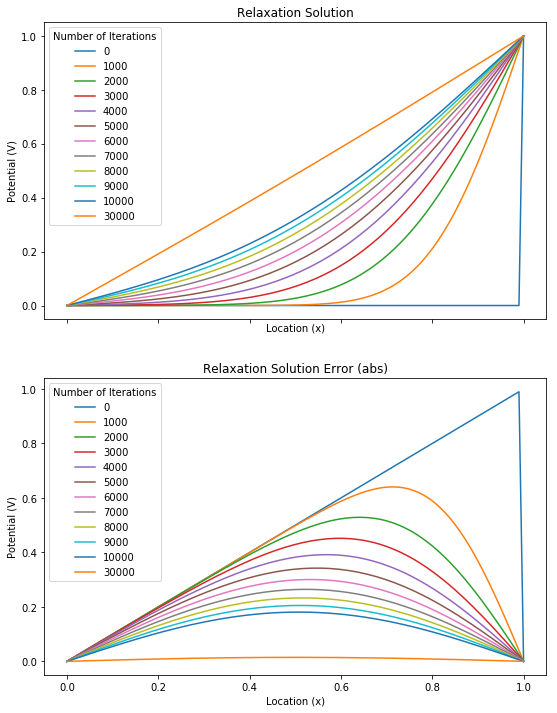

Time taken:  0.13558268547058105  seconds


In [41]:
#create domain and an array of zero potential of same size
x=np.linspace(0,1.0,199)
V=np.zeros(len(x))

#boundary condition
V[0],V[-1]=0.0,1.0

#number of iterations
N=10999

#set up figure
fig,ax=plt.subplots(2,sharex=True,figsize=(9,12))

#chi squared
X=[]

"""measure time"""
begin=time.time()

#iteration
for n in np.arange(N):
    V[1:-1]=(V[0:-2]+V[2:])/2.0
    if (n % 1000 == 0): 
        ax[0].plot(x, V, label=str(n)) #relaxation plot
        ax[1].plot(x, np.abs(V-x), label=str(n)) #error plot
        X.append((n,(V-x)**2/len(x))) # append chi squared
        
#after many iterations
for n in range(19002):
    V[1:-1]=(V[0:-2]+V[2:])/2.0
    if (n%1000 ==0):
        X.append((n+N,(V-x)**2/len(x)))

#plots
ax[0].plot(x, V, label=str(N+n))
ax[1].plot(x, np.abs(V-x), label=str(N+n))
X.append((n+N,(V-x)**2/len(x)))

"""end measure time"""
end=time.time()

#plots
ax[0].set_title("Relaxation Solution")
ax[1].set_title("Relaxation Solution Error (abs)")
for i in np.arange(2):
    ax[i].legend(title='Number of Iterations')
    ax[i].set_xlabel('Location (x)')
    ax[i].set_ylabel('Potential (V)')
plt.show()

print("Time taken: ",end-begin," seconds")

After many iterations $(>30000)$, the solution closely approximates the form $V(x)=x$ and the absolute value error approaches 0.  
Finding chi squared of the above error may be useful.

In [42]:
a="Number of Iterations"
b="Chi Squared"
print( f"{a:{25}} {b:{31}}" )

for i,j in X[1:]:
    a=np.sum(j)
    print( f"{i} {a:{30}.{6}}" )

Number of Iterations      Chi Squared                    
1000                       0.177646
2000                       0.128786
3000                      0.0971892
4000                      0.0745299
5000                      0.0575707
6000                      0.0446222
7000                      0.0346414
8000                      0.0269133
9000                      0.0209166
10000                      0.0162588
10999                      0.0126424
11999                      0.0098283
12999                     0.00764071
13999                     0.00594008
14999                     0.00461799
15999                     0.00359016
16999                      0.0027911
17999                     0.00216989
18999                     0.00168694
19999                     0.00131148
20999                     0.00101958
21999                    0.000792654
22999                    0.000616234
23999                    0.000479079
24999                    0.000372451
25999                    0

Without delving deep into statistics, since the chi squared eventually approaches very small number ($<0.0002$), and chi squared can be used to measure the 'goodness of fit', which is similar to what we are trying to accomplish, thus it can be used to enforce the idea that the numerical solution found just now is a close approximation to the analytical.

## Numerical Method 2: Convolution

By inspection, instead of using numpy addition, the problem can be done using discrete Convolution process:

$$V^*[n]=V[n]*psf[n]=\sum_k V[k]\cdot psf[n-k]$$

Note: Typical literature about convolution uses integral form rather than a sum. However, given the nature of classical computer (discrete) with its finite memory, it can never fully capture the topology of real numbers, which is a requirement of an integral (can only approximate) because it cannot represent the density of rationals and irrationals of $\mathbb{R}$ without running out of memory. Therefore a discrete sum seems more appropriate whenever we are talking about convolution in the context of computation.

$V^*[n]$ is the potential after a single convolution process, $V[n]$ a before, and $psf$ is the point spread function or a matrix to be convolved with respect to with dimension $1\times p$. It's obvious that the point spread function for solving this Laplacie equation is

$$psf = \frac{1}{2}\begin{bmatrix}1 & 0 & 1 \end{bmatrix}$$

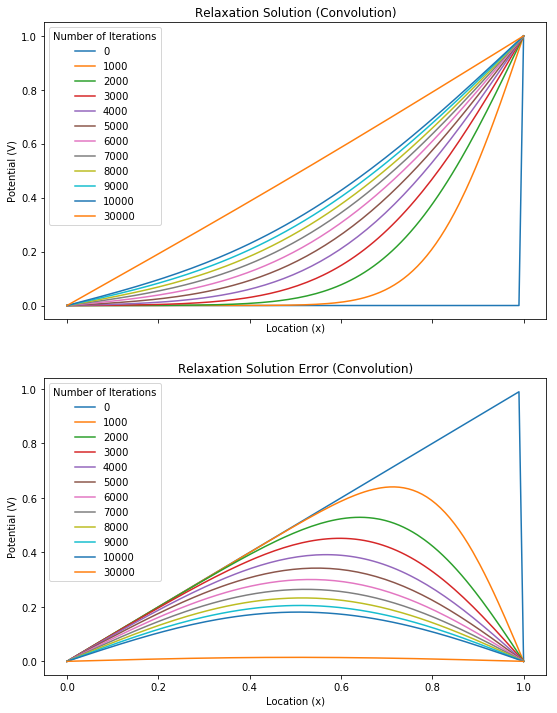

Time taken:  0.5463762283325195  seconds


In [43]:
#set up spatial coordinate, potential array
x=np.linspace(0,1.0,199)
V=np.zeros(len(x))

#boundary
V[0],V[-1]=0.0,1.0

#use scipy.signal.convolve
psf=np.array([1,0,1])/2.0 # point spread function

N=10999

#set up figure
fig,ax=plt.subplots(2,sharex=True,figsize=(9,12))

#chi squared
X=[]

"""measure time"""
begin=time.time()

#iteration
for n in np.arange(N):
    V=scipy.signal.convolve(V,psf)[1:-1] #cut dimension at the corners
    V[0],V[-1]=0.0,1.0 # need to define boundary condition
    if (n % 1000 == 0): 
        ax[0].plot(x, V, label=str(n)) #relaxation plot
        ax[1].plot(x, np.abs(V-x), label=str(n)) #error plot
        X.append((n,(V-x)**2/len(x))) # append chi squared
        
#after many iterations
for n in range(19002):
    V=scipy.signal.convolve(V,psf)[1:-1]
    V[0],V[-1]=0.0,1.0 #need to redefine boundary condition
    if (n%1000 ==0):
        X.append((n+N,(V-x)**2/len(x)))
ax[0].plot(x, V, label=str(N+n))
ax[1].plot(x, np.abs(V-x), label=str(N+n))

"""end time measure"""
end=time.time()

#plots
ax[0].set_title("Relaxation Solution (Convolution)")
ax[1].set_title("Relaxation Solution Error (Convolution)")
for i in np.arange(2):
    ax[i].legend(title='Number of Iterations')
    ax[i].set_xlabel('Location (x)')
    ax[i].set_ylabel('Potential (V)')
plt.show()

print("Time taken: ",end-begin," seconds")

Similarly, chi squared:

In [44]:
print("For Convolution:")
a="Number of Iterations"
b="Chi Squared"
print( f"{a:{25}} {b:{31}}" )

plotx=[]
ploty=[]

for i,j in X[1:]:
    a=np.sum(j)
    print( f"{i} {a:{30}.{6}}" )
    plotx.append(i)
    ploty.append(a)

For Convolution:
Number of Iterations      Chi Squared                    
1000                       0.177646
2000                       0.128786
3000                      0.0971892
4000                      0.0745299
5000                      0.0575707
6000                      0.0446222
7000                      0.0346414
8000                      0.0269133
9000                      0.0209166
10000                      0.0162588
10999                      0.0126424
11999                      0.0098283
12999                     0.00764071
13999                     0.00594008
14999                     0.00461799
15999                     0.00359016
16999                      0.0027911
17999                     0.00216989
18999                     0.00168694
19999                     0.00131148
20999                     0.00101958
21999                    0.000792654
22999                    0.000616234
23999                    0.000479079
24999                    0.000372451
25999    

It's relatively straight forward to see that the convolution operation (with psf above) on the array (of potential) is identical to that of the Matrix Addition method, so no quantitative comparison is necessary. But one can visually check that they've produced identical plots and chi squared

## Discussion 1: Convergence Rate

It would be nice to have a quantitative statement about the convergence rate using statistical tool like chi squared.

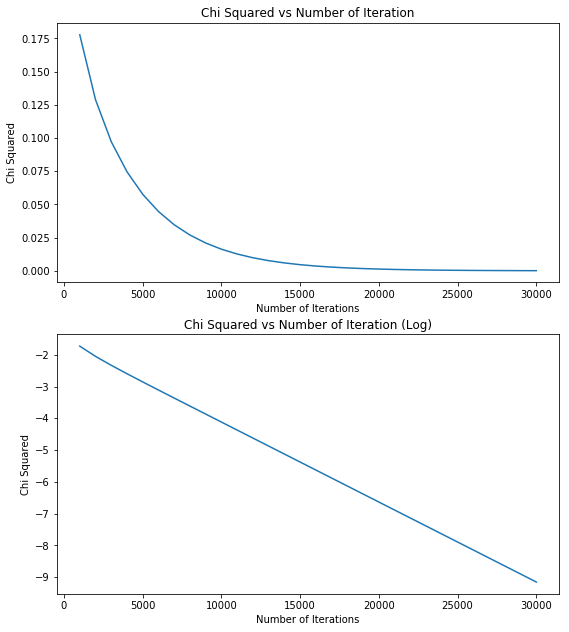

In [45]:
fig,ax=plt.subplots(2,figsize=[9,10.5])
ax[0].set_title("Chi Squared vs Number of Iteration")
ax[1].set_title("Chi Squared vs Number of Iteration (Log)")
ax[0].plot(plotx,ploty)
ax[1].plot(plotx,np.log(ploty))

for i in np.arange(2):
    ax[i].set_xlabel("Number of Iterations")
    ax[i].set_ylabel("Chi Squared")
    
plt.show()

Chi squared did not disappoint here and produced a neat result. Using this, I claim the convergence rate of this algorithm is logrithmic with respect to the number of iterations.

## Discussion 2: Convolution vs Matrix addition

Since convolution operation is mathematically identical to the matrix addition approach defined above, results were obviously identical. In terms of computation efficiency, simple numpy addition is a clear winner (0.13s vs  0.42s), but Convolution has one advantage over addition: its easy invertibility.
  
In the matrix addition case, each iteration destroys information by combining two real numbers in adjacent elements, therefore there is no way to inverse it without keeping track of every single elements, which is not useful at all. However, in convolution, to inverse (deconvolve) it, one only needs to keep track of the point spread function so that invert can be easily achieved:

In [46]:
for i in range(30000):
    V,Vremainder=scipy.signal.deconvolve(V,psf) 
    #deconvolve destroys edge elements, so pad them with boundary
    V=np.pad(V,(1,1),'constant',constant_values=(0,1))

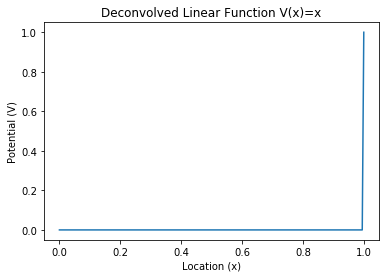

In [47]:
plt.title("Deconvolved Linear Function V(x)=x")
plt.xlabel("Location (x)")
plt.ylabel("Potential (V)")
plt.plot(x,V)
plt.show()

Hence giving us the original potential.

# Task2

In Task 1, approximation to $V(x,y)$ was derived:
$$ V(x_i, y_j) = V_{i,j} = \frac{V_{i-1,j} + V_{i+1,j} + V_{i,j-1} + V_{i,j+1}}{4} $$.  
Using the above equation, I numerically solve Griffiths example 3.4:  
  
Two infinitely long grounded metal plates lie parallel to the $x-z$ plane, one at $y=0$, the other at $y=a=5cm$.  They are connected at $x=\pm b=\pm 4cm$ by metal strips maintained at a constant potential $V_0=4 volts$ to form a rectangular channel.  A thin layer of insulation at each corner allows the sides to be maintained at different potentials.

The analytical solution to this boundary value problem is given by

  $$ V(x,y) = \frac{4 V_0}{\pi} \sum_{n=1,3,5,...} \frac{1}{n} \frac{\cosh(n \pi x / a)}{\cosh (n \pi b / a)} \sin(n \pi y / a)$$

## Analytical Solution
First note that infinitely long plates implies the potential would be independent of z.
It would be beneficial to discuss some properties associated with the $V(x,y)$ above, most notably that the sum in $V(x,y)$ converges. This is crucial because otherwise, the potential would reach infinity for some points.  
Proof:Let $S_N=\sum^N_{n=1} a_n =\sum^N_{n=1} \frac{1}{n}\frac{cosh(n\pi x/a)}{cosh(n\pi b/a)}sin(n\pi y/a)$ I spent 2 hours after the deadline to prove its convergence, but failed. Most convergence test I usually use rely on $a_n>0$, but $sin(y\pi n/a)$ makes that difficult. May be able to use absolute convergence property but I'm missing one piece of the puzzle: convergence of $\sum |(sin(n\pi x/a)/n)|$. So for now, we just rely on the fact that $a_n\rightarrow 0$ and hope it somehow guarantee the convergence despite the obvious counter example similar to it: $(lim_{n\rightarrow \infty}\frac{1}{n}=0$ but its sum diverges).





There are several ways to visualize the analytical potential solution above. One method is via plt.imshow representation where the magnitude of potential are represented by colormap. Alternatively, we can do a 3D plot since V(x,y) takes on only 2 arguments, x and y (it would be hard to visualize V=V(x,y,z) as that would require a 4 dimensional plot). Here I show both visualizations

In [48]:
#Analytical function V(x,y):
def func(x,y,n,a,b):
    """given inputs x,y,n,a,b , outputs a potential function V(x,y) defined above
    
    args:
        x(np.ndarray): list of x coordinates
        y(np.ndarray): list of y coordinates
        n(int): index to be summed over. must be odd
        a(float): boundary of y 
        b(float): boundary of x
    returns:
        f(float): V(x,y)
    """
    #force even n
    if n%2==0:
        raiseValueError(" n must be an odd integer.")
        
    f=0.5*(np.exp(n*np.pi*x/a)+np.exp(-n*np.pi*x/a))*np.sin(n*np.pi*y/a)/(n*np.cosh(n*np.pi*b/a))
    
    return f


### Visualizeation 1: plt.Imshow (colormap)

In [97]:
#define constants, dimension
a=0.05
b=0.04
xdim=161
ydim=101
#set up coordinates
x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
x,y=np.meshgrid(x,y)

#setup potential array
V_analytic=np.zeros([ydim,xdim])

The sum in $V(x,y)$ is an infinite sum, but obviously any attempt to actually sum it over infinity will be met by memory error. But we already know that the sum converges and has a finite limit $L$. So the task is finding the right $N$ so that terms with $n\geq N\in \mathbb{N}$ contribute very little. Here I claim $N=280$. Not because it is   a sufficiently large number (in my opinion), but python float overflows after this number. 

In the worst case scenario, we can compute it elsewhere like Mathematica that supports very high floating precision ($<10^{10^{14}}$). But N=280 is not the worst number to terminate the sum with since for $a_{279}$, its contributions to the potential are are bounded below $\sim |0.004|$ and this bound gets smaller for higher n.

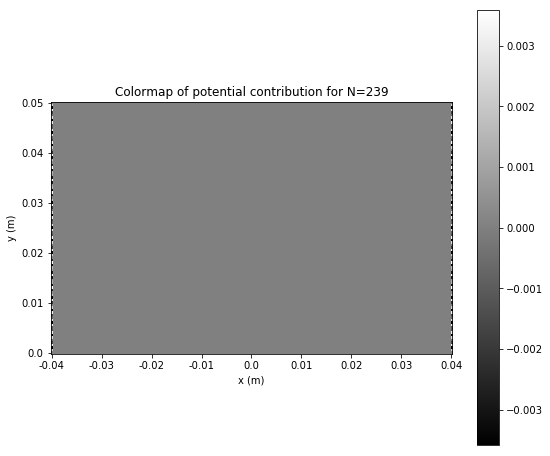

In [98]:

#plots
fig=plt.figure(figsize=[9,8])
ax=fig.add_subplot(111)
cax=ax.imshow(func(x,y,279,a,b),interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential contribution for N=239")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticklabels(np.linspace(-0.05,0.04,10))
ax.set_yticklabels(np.linspace(0.06,0.0,7))
cbar=fig.colorbar(cax)

plt.show()

now let's do the actual summation and plot

In [51]:
#sum over n=1,3,5,7 ...
for m,n in enumerate(range(1,280,2)):
    dummy_V=(4*4/np.pi)*func(x,y,n,a,b)
    V_analytic+=dummy_V


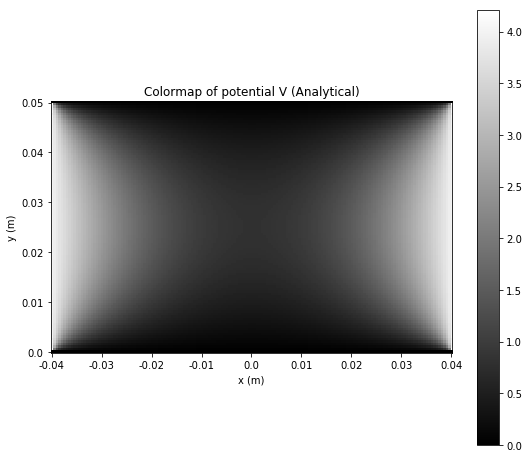

In [52]:
#plots
fig=plt.figure(figsize=[9,8])
ax=fig.add_subplot(111)
cax=ax.imshow(V_analytic,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (Analytical)")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticklabels(np.linspace(-0.05,0.04,10))
ax.set_yticklabels(np.linspace(0.060,0.0,7))
cbar=fig.colorbar(cax)

plt.show()

Something is not right here. The potential ranges from 0.0 to a number larger than 4.0 (~4.3). But examining it reveals that such number only exist on the boundaries:

In [53]:
print("max inside boundary: ",np.max(V_analytic[1:-1,1:-1]))
print("min inside boundary: ",np.min(V_analytic[1:-1,1:-1]))

max inside boundary:  3.92209800145
min inside boundary:  0.0259185693147


So replace the values on the boundary with the correct values; (0.0, 4.0).

In [54]:
# take first and last element and define assert force correct boundary values
V_analytic[0::ydim-1,:]=0.0 
V_analytic[:,0::xdim-1]=4.0

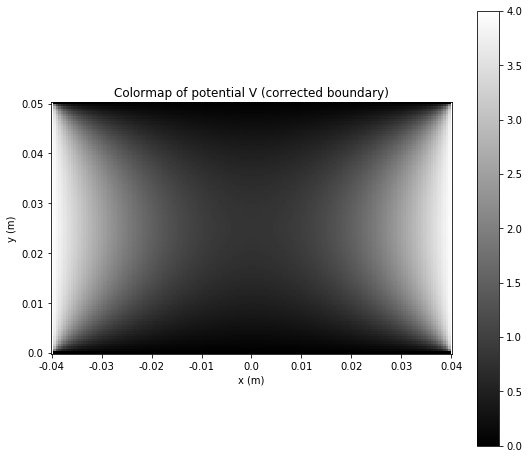

In [55]:

#plots
fig=plt.figure(figsize=[9,8])
ax=fig.add_subplot(111)
cax=ax.imshow(V_analytic,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (corrected boundary)")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticklabels(np.linspace(-0.05,0.04,10))
ax.set_yticklabels(np.linspace(0.06,0.0,7))
cbar=fig.colorbar(cax)

plt.show()

## Visualization 2: 3D plot

as the name suggests, 3D plot of $V(x,y)$ is plotted.

In [56]:
from mpl_toolkits.mplot3d import Axes3D

In [57]:
#setup figure
fig=plt.figure(figsize=[14,8])
ax=fig.add_subplot(111,projection='3d')

#setup dim,coordinates
a=0.05
b=0.04
xdim=161
ydim=101
x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
x,y=np.meshgrid(x,y)

#plot_wireframe require input of multipl 1D arrays.
Z=[]
for i in range(len(x)):
    Z.append(V_analytic[i]/4.0)

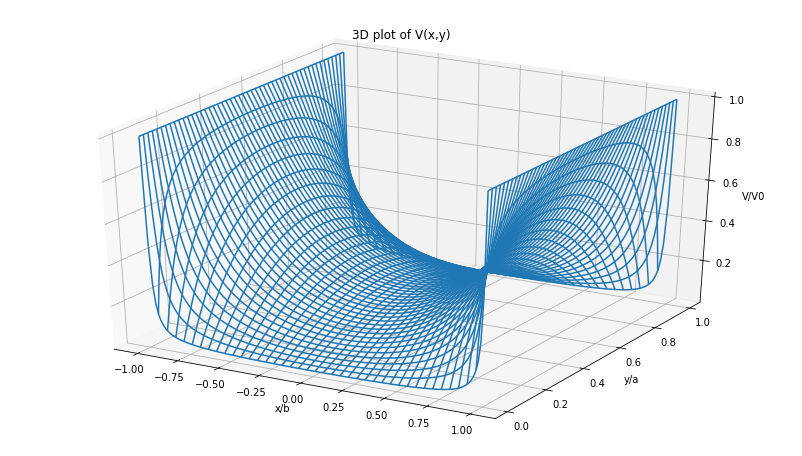

In [58]:
ax.plot_wireframe(x[1:-1]/b,y[1:-1]/a,Z[1:-1])
ax.set_title("3D plot of V(x,y)")
ax.set_xlabel("x/b")
ax.set_ylabel("y/a")
ax.set_zlabel("V/V0")
plt.show()

One can visually check that this potential is indeed similar to fig 3.21 in Griffith's book (http://www.vijaygarhjrcollege.com/documents/Study%20Material%20_Electrodynamics-Griffiths.pdf). But the potential in his book is upside down (or mine is).

## Method 1: Numerical Solution (Matrix addition)
The general approach is identical to the 1D case, just with different boundary conditions and an extra dimension

In [103]:
#setup coordinates/dimension
a=0.05
b=0.04
xdim=161
ydim=101

v=np.zeros([ydim,xdim])
x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
x,y=np.meshgrid(x,y)

#boundary condition
v[:,0::xdim-1]=4
v[0::ydim-1,:]=0


noticing that array indexing is of the form $v[y,x]$ makes things easier

In [104]:
v.shape

(101, 161)

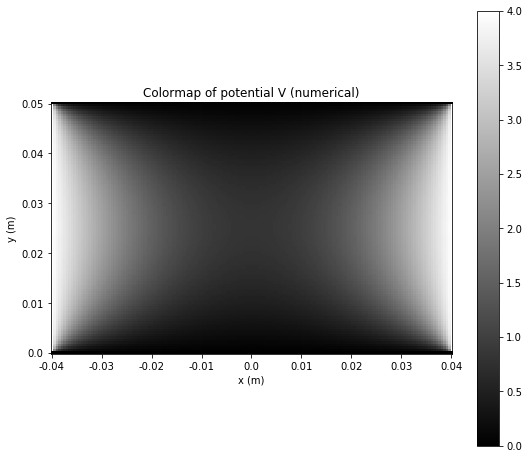

In [105]:
nsteps=19999
for n in range(nsteps):
    vcopy=copy.deepcopy(v)
    v[1:-1,:]=(vcopy[0:-2,:]+vcopy[2:,:])/4.0
    v1=copy.deepcopy(v)
    v[:,1:-1]=(vcopy[:,0:-2]+vcopy[:,2:])/4.0
    v2=copy.deepcopy(v)
    v=v1+v2
    
    #redfine boundary
    v[:,0::xdim-1]=4
    v[0::ydim-1,:]=0
    

    
#plots
fig=plt.figure(figsize=[9,8])
ax=fig.add_subplot(111)
cax=ax.imshow(v,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (numerical)")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticklabels(np.linspace(-0.05,0.04,10))
ax.set_yticklabels(np.linspace(0.06,0.0,7))
cbar=fig.colorbar(cax)

plt.show()

3D

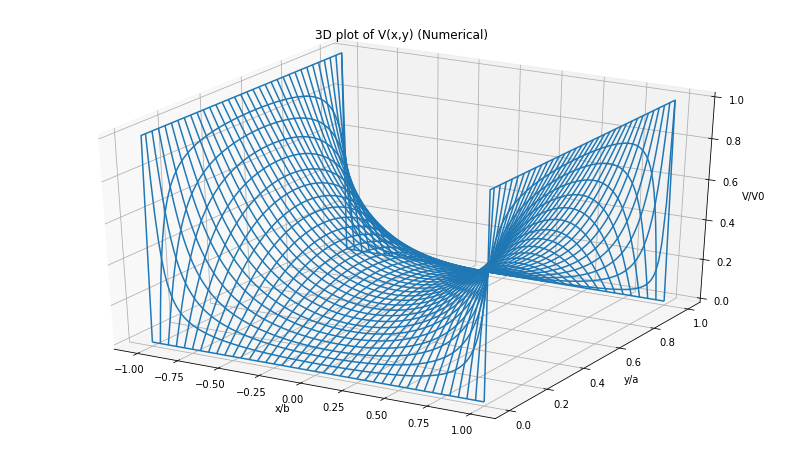

In [62]:
fig=plt.figure(figsize=[14,8])
ax=fig.add_subplot(111,projection='3d')

x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
x,y=np.meshgrid(x,y)
Z=[]
for i in range(ydim):
    Z.append(v[i]/4.0)


ax.plot_wireframe(x/b,y/a,Z)
ax.set_title("3D plot of V(x,y) (Numerical)")
ax.set_xlabel("x/b")
ax.set_ylabel("y/a")
ax.set_zlabel("V/V0")
plt.show()

## Method 2: Numerical Solution (Convolution)
 I was hesitant to include this since just like in the 1D case, it's obvious that its mathematically identical to the matrix method and all the discussions were done in Task 1. So only results are shown here without any discussion.

In [106]:
#setup coordinates and potential v
a=0.05
b=0.04
xdim=161
ydim=101

x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
v=np.zeros([ydim,xdim])

#boundary condition
v[:,0::xdim-1]=4
v[0::ydim-1,:]=0

In [107]:
#convolve
nsteps=19999
#point spread
psf=np.array([[0,1,0],[1,0,1],[0,1,0]])/4.0
for indx in range(nsteps):
    v=scipy.signal.convolve2d(v,psf)[1:-1,1:-1]
    #redefine boundary
    v[:,0::xdim-1]=4
    v[0::ydim-1,:]=0

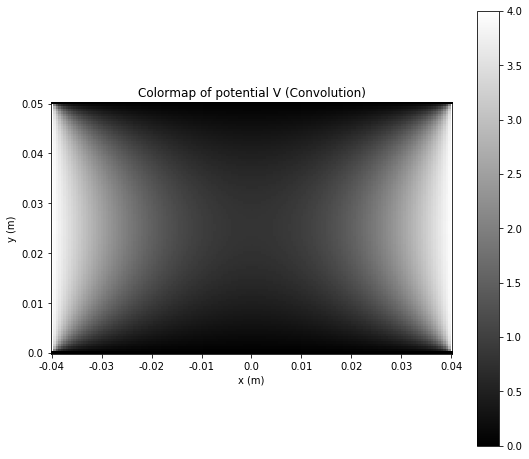

In [108]:

#plots
fig=plt.figure(figsize=[9,8])
ax=fig.add_subplot(111)
cax=ax.imshow(v,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (Convolution)")
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xticklabels(np.linspace(-0.05,0.04,10))
ax.set_yticklabels(np.linspace(0.06,0.0,7))
cbar=fig.colorbar(cax)

plt.show()

## Comparison: Analytical and Numerical

Comparison is done via finding the percent difference between the analytical potential arrays and Numerical potential arrays.

C:\Users\David\Miniconda3\envs\p36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


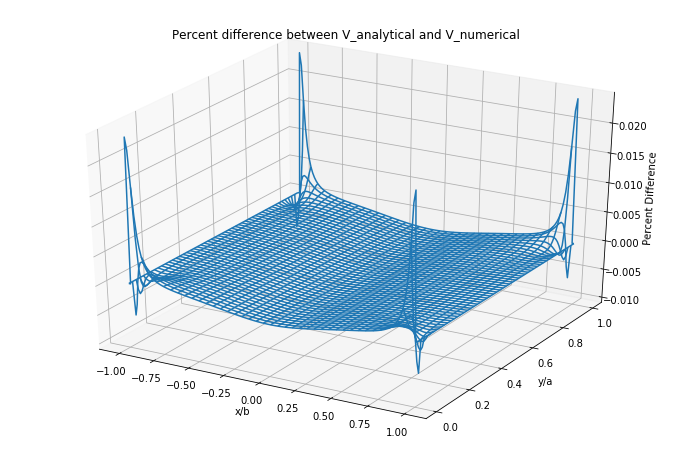

In [66]:
#setup plots
fig=plt.figure(figsize=[12,8])
ax=fig.add_subplot(111,projection='3d')

x=np.linspace(-0.04,0.04,xdim)
y=np.linspace(0,0.05,ydim)
x,y=np.meshgrid(x,y)
Z=[]
for i in range(len(x)):
    Z.append(((v[i]-V_analytic[i])/V_analytic[i]))

#ax.imshow()
ax.plot_wireframe(x[1:-1]/b,y[1:-1]/a,Z[1:-1])
ax.set_title("Percent difference between V_analytical and V_numerical")
ax.set_xlabel("x/b")
ax.set_ylabel("y/a")
ax.set_zlabel("Percent Difference ")
plt.show()

The highhest percent difference present (mostly near the edges) is:

In [67]:
nZ=np.array(Z)
#only include non nan values.
print(str( np.max( nZ[np.where(np.invert(np.isnan(nZ)))] )*100)+" %"  )

2.43378396079 %


So analytical and numerical values of potential $V(x,y)$ agree closely near non-edges.

# Task 3
A coaxial cable has inner conductor radius of $r_a=1mm$ and outer conductor radius of $r_b=5mm$.  Assume that the outer conductor is grounded and the inner conductor is at potential $V_0=9 volts$.

Obtain a numerical solution to Laplace's equation in the region between the inner and outer conductors.  Plot and discuss.

What is the potential midway between the inner and outer conductors (at $r=3mm$)?  

## Analytical Solution

First I solve the problem analytically using Static Electromagnetism:

Potential V is related to the electric field by $$V=-\int \vec{E}\cdot dl$$,  
and using Gauss' law:
$$\oint \vec{E}\cdot dS=\frac{Q_{enc}}{\epsilon_0}$$
$$\implies E=\frac{\lambda}{2 \pi r \epsilon_0}$$
which is radially symmetric

where $Q_{enc}$ is the enclosed charge in gauss surface, $\lambda$ is the uniform charge density, $\epsilon_0$ a permittivity in vacuum, and $r$ a distance distance from the axis of the cylinder.

Then since the line in which we integrate is doesn't matter as $\vec{E}$ is conservative, choose $dl=dr$ so that 
$$\Delta V=-\int_{a}^r \vec{E}\cdot dr$$
$$\implies V=\frac{\lambda}{2\pi \epsilon_0}ln(a/r)+9$$
Furthermore 
$$V(b)=0 \implies \lambda=9\frac{2\pi \epsilon_0}{ln(5)}\implies V(r)=9\frac{ln(a/r)}{ln(5)}+9$$
Can manually check that $$V(a)=9 V,V(b)=0 V$$
and that $$\implies V(3a)=9\frac{ln(1/3)}{ln(5)}+9\approx 2.857 Volts$$.  
For $r<a$ and $r>b$, consider

$E=0$ for $r<a$ since no charged inclosed, and $V(r<a)=const=d, V(a)=9\implies d=9$, so potential for $r<a$ is 9.

Similarly, $E=0$ for $r>b$ and $V(r>b)=const=p$, $V(b)=0 \implies b=0$, so potential for $r>b$ is 0.

Again, Potential is independent of z because of symmetry (infinitely long)

In [68]:
def V_cylinder(x,y,a,b):
    """finds analytical solutions of potential above
    
    args:
        x(np.ndarray) x coordinate
        y(np.ndarray): y coordinate
        a(int) boundary of inner cylinder
        b(int): boundary of outer cylinder
    returns:
        potential V(x,y) """
    r=np.sqrt(x**2+y**2)
    V=9*np.log(a/r)/np.log(5)+9
    
    return V

The analytical solution of V(3 mm) is

In [69]:
print("V(3 mm): ",V_cylinder(0.0,0.03,0.01,0.05)," volts")

V(3 mm):  2.85654424963  volts


Now for visualizing this potnetial:

C:\Users\David\Miniconda3\envs\p36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


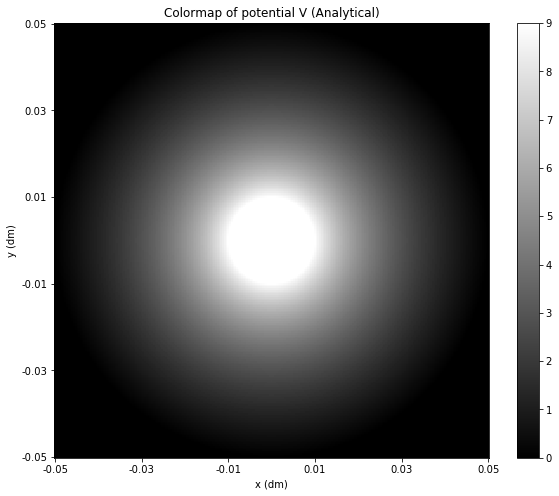

In [70]:
#setup coordinates
x=np.linspace(-0.05,0.05,251)
y=np.linspace(-0.05,0.05,251)
x,y=np.meshgrid(x,y)
V=V_cylinder(x,y,0.01,0.05)

#r
r=np.sqrt(x**2+y**2)

#boundary
V_coord_g9=np.where(V>=9.0) #coordinate of potential >0
V[V_coord_g9]=9.0 #set them to 9
V[np.isnan(V)]=0.0 #make nan a 0.

r_g9=np.where(r>=0.05) # coordinate of r > 0.05
V[r_g9]=0 # set them to 0

V[np.isnan(V)]=0



#plots
fig=plt.figure(figsize=[10,8])
ax=fig.add_subplot(111)
cax=ax.imshow(V,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (Analytical)")
ax.set_xlabel('x (dm)')
ax.set_ylabel('y (dm)')
ax.set_xticklabels(np.linspace(-0.07,0.09,9))
ax.set_yticklabels(np.linspace(0.07,-0.09,9))
cbar=fig.colorbar(cax)

plt.show()

as well as a 3d plot

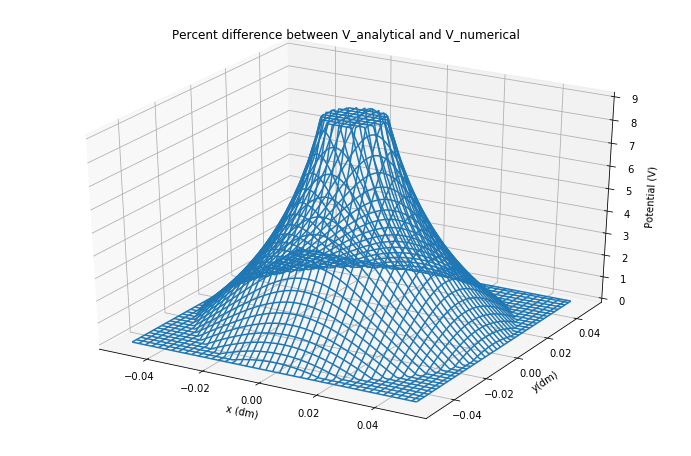

In [80]:
#setup figures
fig=plt.figure(figsize=[12,8])
ax=fig.add_subplot(111,projection='3d')

x=np.linspace(-0.05,0.05,251)
y=np.linspace(-0.05,0.05,251)
x,y=np.meshgrid(x,y)

Z=[]
for i in range(251):
    Z.append(V[i])

#ax.imshow()
ax.plot_wireframe(x,y,Z)
ax.set_title("Percent difference between V_analytical and V_numerical")
ax.set_xlabel("x (dm)")
ax.set_ylabel("y(dm)")
ax.set_zlabel("Potential (V)")
plt.show()

## Numerical Solution (Matrix Addition)

Given the nature of the question, it is tempting to work in a spherical (polar upto symmetry). But it is more tempting to work in Cartesian coordinate where we can simply apply the same method as in Task 2 since it would be easier. First we need to draw the circles that would represent the bounaries

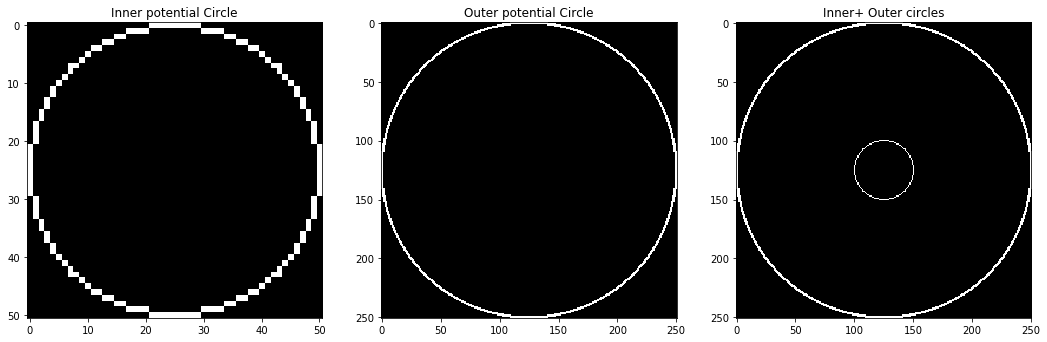

In [114]:
innerd=50+1 #inner diameter
outd=250+1 #outer diameter
ir=innerd//2 #inner radius
outr=outd//2 #outer radius

#setup plots
fig,ax=plt.subplots(1,3,figsize=[18,6])


#setup inner potential array
Vinner=np.zeros([innerd,innerd])


epsilon=5.0 #threshold for drawing inner circle
for y in range(innerd):
    for x in range(innerd):
        if np.abs((x-ir)**2+(y-ir)**2-ir**2) < epsilon**2:
            Vinner[y,x]=10
ax[0].set_title("Inner potential Circle")
ax[0].imshow(Vinner,cmap='gray')


#setup outer potential array
Vouter=np.zeros([outd,outd])
epsilon=16.2 #threshold for outer circle
for y in range(outd):
    for x in range(outd):
        if np.abs((x-outr)**2+(y-outr)**2-outr**2) < epsilon**2:
            Vouter[y,x]=10
ax[1].set_title("Outer potential Circle")
ax[1].imshow(Vouter,cmap='gray')


#to add the two arrays, pad the inner array with zeros:
dif=outr-ir
Vinner_padded=np.pad(Vinner,((dif,dif),(dif,dif)),'constant',constant_values=((0,0),(0,0)))

#need to get coordinates of the circles to specify boundary potentials later
Vinner_coordinates=np.where(Vinner_padded==10)
Vouter_coordinates=np.where(Vouter==10)    

ax[2].set_title("Inner+ Outer circles")
ax[2].imshow(Vinner_padded+Vouter,cmap='gray')

plt.show()



And do the same thing as in Task2 to find the solution via matrix addition:

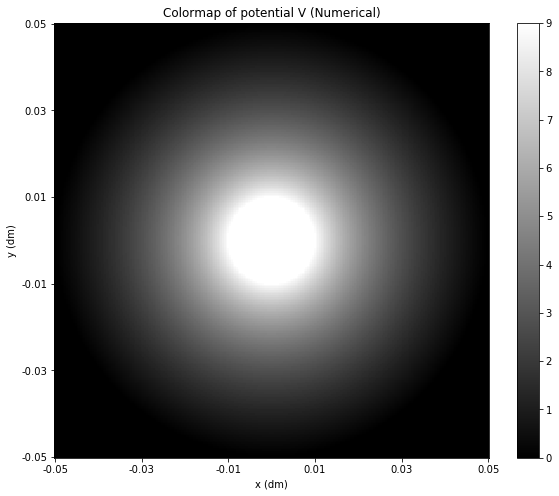

In [111]:
#setup potential
v=Vinner_padded+Vouter

#boundary condition using the coordinates found earlier
vin=Vinner_coordinates
vout=Vouter_coordinates
v[vin]=9.0
v[vout]=0.0

#iterations
nsteps=299999
for n in range(nsteps):
    vcopy=copy.deepcopy(v)
    v[1:-1,:]=(vcopy[0:-2,:]+vcopy[2:,:])/4.0
    v1=copy.deepcopy(v)
    v[:,1:-1]=(vcopy[:,0:-2]+vcopy[:,2:])/4.0
    v2=copy.deepcopy(v)
    v=v1+v2
    
    #redfine boundary conditions
    v[vin]=9.0
    v[vout]=0.0

fig=plt.figure(figsize=[10,8])
ax=fig.add_subplot(111)
cax=ax.imshow(v,interpolation='nearest',cmap='gray')

ax.set_title("Colormap of potential V (Numerical)")
ax.set_xlabel('x (dm)')
ax.set_ylabel('y (dm)')
ax.set_xticklabels(np.linspace(-0.07,0.09,9))
ax.set_yticklabels(np.linspace(0.07,-0.09,9))
cbar=fig.colorbar(cax)

plt.show()

And 3D plot for better visualization:

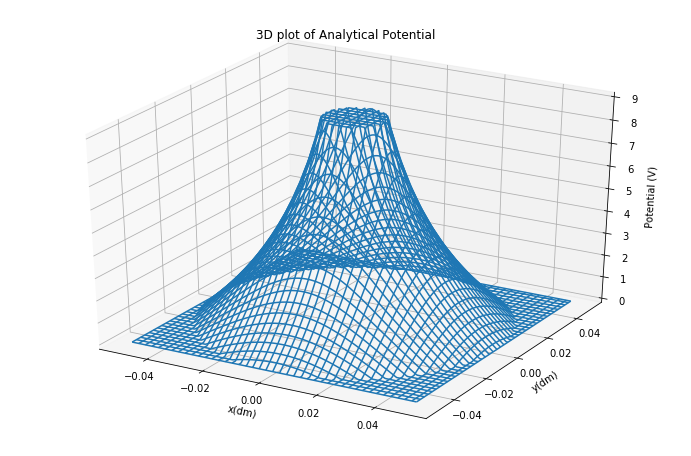

In [112]:
fig=plt.figure(figsize=[12,8])
ax=fig.add_subplot(111,projection='3d')

x=np.linspace(-0.05,0.05,outd)
y=np.linspace(-0.05,0.05,outd)
x,y=np.meshgrid(x,y)

Z=[]
for i in range(outd):
    Z.append(V[i])

#ax.imshow()
ax.plot_wireframe(x,y,Z)
ax.set_title("3D plot of Analytical Potential")
ax.set_xlabel("x(dm)")
ax.set_ylabel("y(dm)")
ax.set_zlabel("Potential (V)")
plt.show()

## Discussion: Analytical vs Numerical

Here I examine how close the numerical solution is to the Analytical.

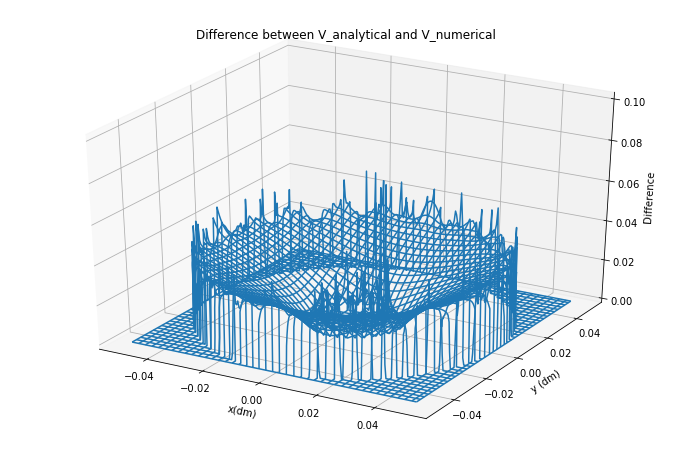

In [113]:
#setup fig
fig=plt.figure(figsize=[12,8])
ax=fig.add_subplot(111,projection='3d')

x=np.linspace(-0.05,0.05,outd)
y=np.linspace(-0.05,0.05,outd)
x,y=np.meshgrid(x,y)

Z=[]
for i in range(outd):
    Z.append(np.abs((V[i]-v[i]))) # subtract analytical from numerical
    
ax.plot_wireframe(x,y,Z)
ax.set_title("Difference between V_analytical and V_numerical")
ax.set_xlabel("x(dm)")
ax.set_ylabel("y (dm)")
ax.set_zlabel("Difference ")
plt.show()

The difference is bounded above by

In [88]:
print(np.max(np.array(Z))*100," %")

10.1045034739  %


But ideally, we want a negligible percent difference. Consider a top-down view of percent difference:

C:\Users\David\Miniconda3\envs\p36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


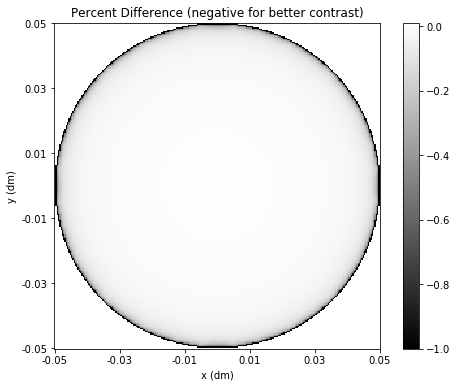

In [93]:
fig=plt.figure(figsize=[8,6])
ax=fig.add_subplot(111)
#percent difference
pplot=(v-V)/V
cax=ax.imshow(pplot,interpolation='nearest',cmap='gray')

ax.set_title("Percent Difference (negative for better contrast)")
ax.set_xlabel('x (dm)')
ax.set_ylabel('y (dm)')
ax.set_xticklabels(np.linspace(-0.07,0.09,9))
ax.set_yticklabels(np.linspace(0.07,-0.09,9))
cbar=fig.colorbar(cax)

plt.show()

Large percent differences only reside near the outer boundaries. So try removing all points with $r> 4 mm$

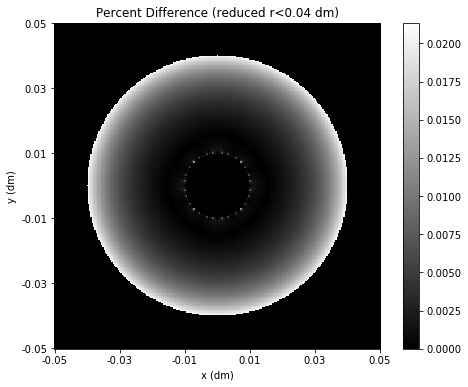

In [95]:
x=np.linspace(-0.05,0.05,251)
y=np.linspace(-0.05,0.05,251)
x,y=np.meshgrid(x,y)
#remove
z=np.sqrt(x**2+y**2)>0.040
pplot[z]=0.

fig=plt.figure(figsize=[8,6])
ax=fig.add_subplot(111)
cax=ax.imshow(np.abs(pplot),interpolation='nearest',cmap='gray')

ax.set_title("Percent Difference (reduced r<0.04 dm)")
ax.set_xlabel('x (dm)')
ax.set_ylabel('y (dm)')
ax.set_xticklabels(np.linspace(-0.07,0.09,9))
ax.set_yticklabels(np.linspace(0.07,-0.09,9))
cbar=fig.colorbar(cax)

plt.show()


which reduces the percent error down to $< 2\%$. We can accept this numerical solution as long as we stay away from the outer boundaries, and the numerical solution at $r=3 mm$ is

In [78]:
num3mm=v[251//2,251*8//10]
num3mm

2.8381768982573226

with a percent difference:

In [79]:
print ("percent difference: ",100*np.abs(num3mm-V_cylinder(0.0,0.03,0.01,0.05))/V_cylinder(0.0,0.03,0.01,0.05),'%')

percent difference:  0.642992012857 %


Ideally, I would've liked to spend more time perfecting the numerical solution, but this is all I can print out for this document. The problem is most likely caused by drawing a bad circle with insufficient dimension to approximate the circle.

# Conclusion

Comparison between Numerical Solution and Analytical solutions for 3 different physical systems, 1 dimensional potential, a square potential, and cylindrical potential were conducted. Similarities between the analytical and numerical solutions suggests the numerical method is a good approximations to the systems above, and they can perhaps be extended to solve Laplace Equations of any physical systems where the analytical solutions are challenging or impossible to find. It it however, worth noting that some unusual behaviors of the solution may present themselves near the boundaries. 